# SARIMAX on electricity carbon intensity

The website [**electricitymap.org**](https://electricitymap.org) provides real-time data-viz about the origin of electricity consumed around the world. In particular, it provides (sub) hourly view of the CO2-intensity of electricity in grams of CO2-equivalent per kWh electricity consumed (gCO2e/kWh).

<img src='electricitymap.jpg' width = 500>


Carbon intensity flucutates a lot depending on seasons, weather conditions, imports from neighbors countries, etc...

Your goal is to **forecast the hourly carbon intensity of electricity in France up to 48 hours ahead** so as to inform when is best to consumer electricity (e.g. charge electric car)

## Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

In [2]:
# Load the 50Mo CSV!
df = pd.read_csv('electricity_map_france.csv', parse_dates=['datetime'], index_col=['datetime'])

### Your challenge
- Your goal is to predict `carbon_intensity_avg` up to 48h ahead.
- We have 6 years of data at hourly granularity! Enough to make proper `cross_validated` score of `rmpe` over the whole dataset!
- You have access to exogeneous forecast prefixed by `latest_forecasted_` 
    - e.g. you can use `latest_forecasted_price_avg(t+i)` when trying to predict `carbon_intensity_avg(t+i)`
    - for i in [1..48]

### Hints

- You can build a `SARMIAX` model with `exog` features
- Or, you can build your own "traditional" ML-based model, optimizing for the 48h ahead time horizon

## Your turn

In [3]:
data = df[['carbon_intensity_avg', 'latest_forecasted_price_avg', 'latest_forecasted_consumption_avg']].set_index(df.index)
data = data.dropna(axis=0)
"""for col in ['carbon_intensity_avg', 'latest_forecasted_price_avg', 'latest_forecasted_consumption_avg']:
    data[col].fillna(method='bfill', inplace=True)"""

"for col in ['carbon_intensity_avg', 'latest_forecasted_price_avg', 'latest_forecasted_consumption_avg']:\n    data[col].fillna(method='bfill', inplace=True)"

In [4]:
y = pd.DataFrame(data['carbon_intensity_avg'])
z = pd.DataFrame(data['latest_forecasted_price_avg'])
w = pd.DataFrame(data['latest_forecasted_consumption_avg'].astype('int64'))

In [5]:
y_train, y_test = y.loc[:'2018-12-01'], y.loc['2019-01-01':]
z_train, z_test = z.loc[:'2018-12-01'], z.loc['2019-01-01':]
w_train, w_test = w.loc[:'2018-12-01'], w.loc['2019-01-01':]

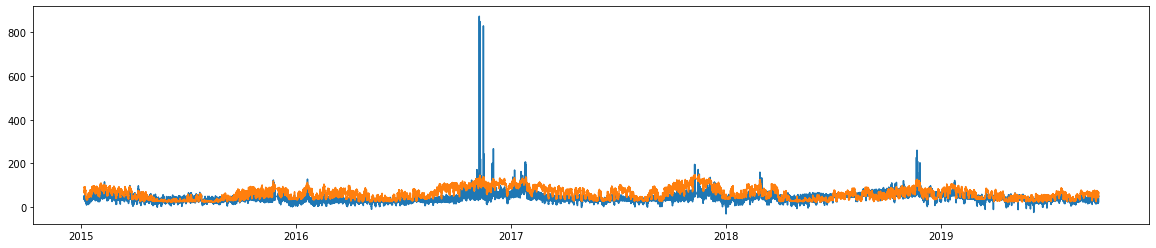

In [6]:
#%matplotlib widget
%matplotlib inline
plt.subplots(1,1,figsize=(20,4))
plt.plot(z); plt.plot(y)
plt.show()

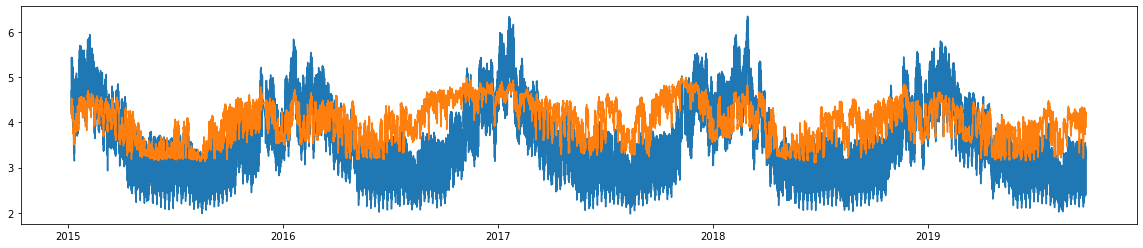

In [7]:
plt.subplots(1,1,figsize=(20,4))
plt.plot((w.iloc[:])/15000);
plt.plot(np.log(y)); 
plt.show()

#### Rolling-mean plot

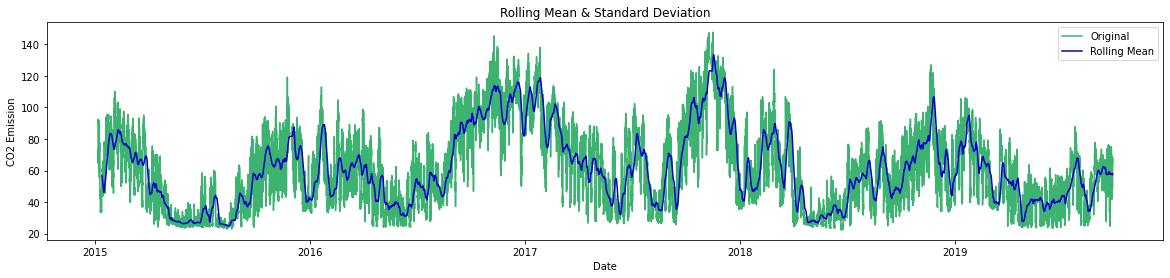

In [8]:
roll_mean = y.rolling(window=168, center=False).mean()
roll_std = y.rolling(window=168, center=False).std()

plt.subplots(1,1,figsize=(20,4))
plt.plot(y, color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
#plt.plot(roll_std, color='orangered', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date'), plt.ylabel('CO2 Emission')
plt.show(block=False)

In [9]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(y):
    result = adfuller(y) #regression='ctt', 'ct', 'c', 'nc'
    labels = ["ADF Test Statistic", 'p-value', "#Lags Used", "No. of observations"]
    for value, label in zip(result, labels):
        print(label,':',str(value))
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
        
    if result[1] <= 0.05:
        print("Strong Evidence against null hypothesis(Ho). Data has no unit root and is stationary")
    else:
        print("Weak Evidence against null hypothesis(H1), time series has a unit root indicating it is non-stationary ")

adfuller_test(np.log(y.carbon_intensity_avg))

ADF Test Statistic : -9.755819839430163
p-value : 7.795026401957061e-17
#Lags Used : 54
No. of observations : 40758
Critical Values:
	1%: -3.43051045222762
	5%: -2.861610916234986
	10%: -2.566807746428161
Strong Evidence against null hypothesis(Ho). Data has no unit root and is stationary


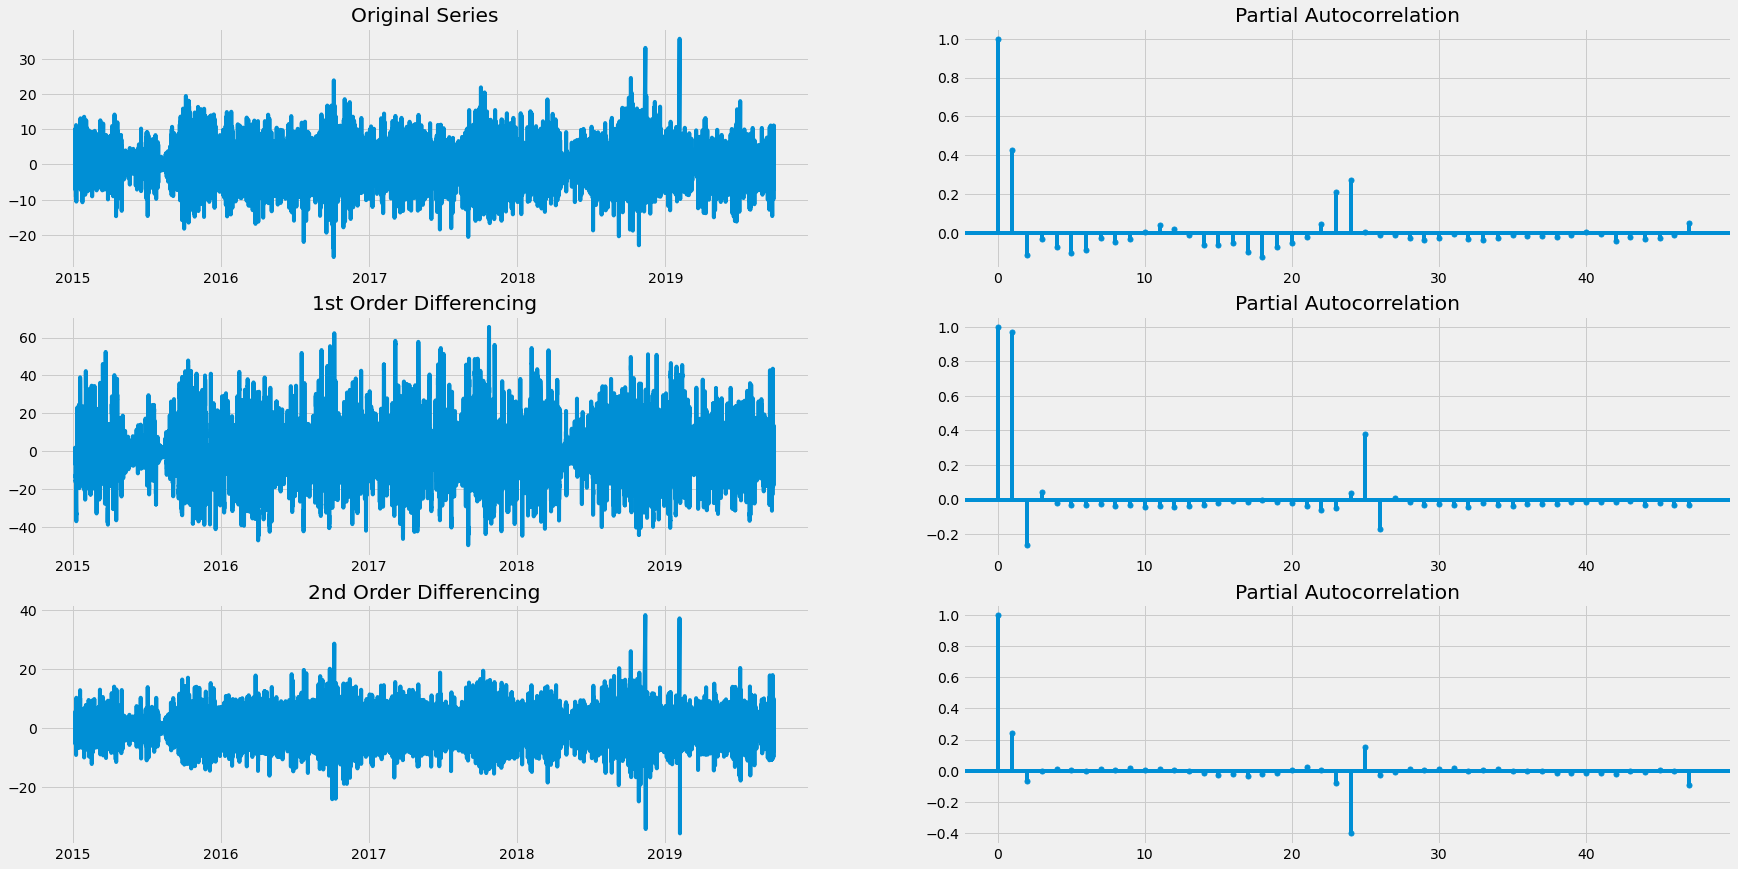

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(27,14)})
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(y.carbon_intensity_avg.diff(1).dropna()); axes[0, 0].set_title('Original Series')
plot_pacf(y.carbon_intensity_avg.diff(1).dropna(), ax=axes[0, 1])

axes[1, 0].plot(y.carbon_intensity_avg.diff(24)); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(y.carbon_intensity_avg.diff(24).dropna(), ax=axes[1, 1]); 

axes[2, 0].plot(y.carbon_intensity_avg.diff(24).diff(1)); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(y.carbon_intensity_avg.diff(24).diff(1).dropna(), ax=axes[2, 1])

plt.show()

In [11]:
import statsmodels.api as sm

sd_24 = sm.tsa.seasonal_decompose(y_train, period=168) #extracting daily seasonality from raw data
sd_168 = sm.tsa.seasonal_decompose(y_train - np.array(sd_24.seasonal).reshape(-1,1), period=168)
sd_8766 = sm.tsa.seasonal_decompose(y_train - np.array(sd_168.seasonal).reshape(-1,1), period=52)

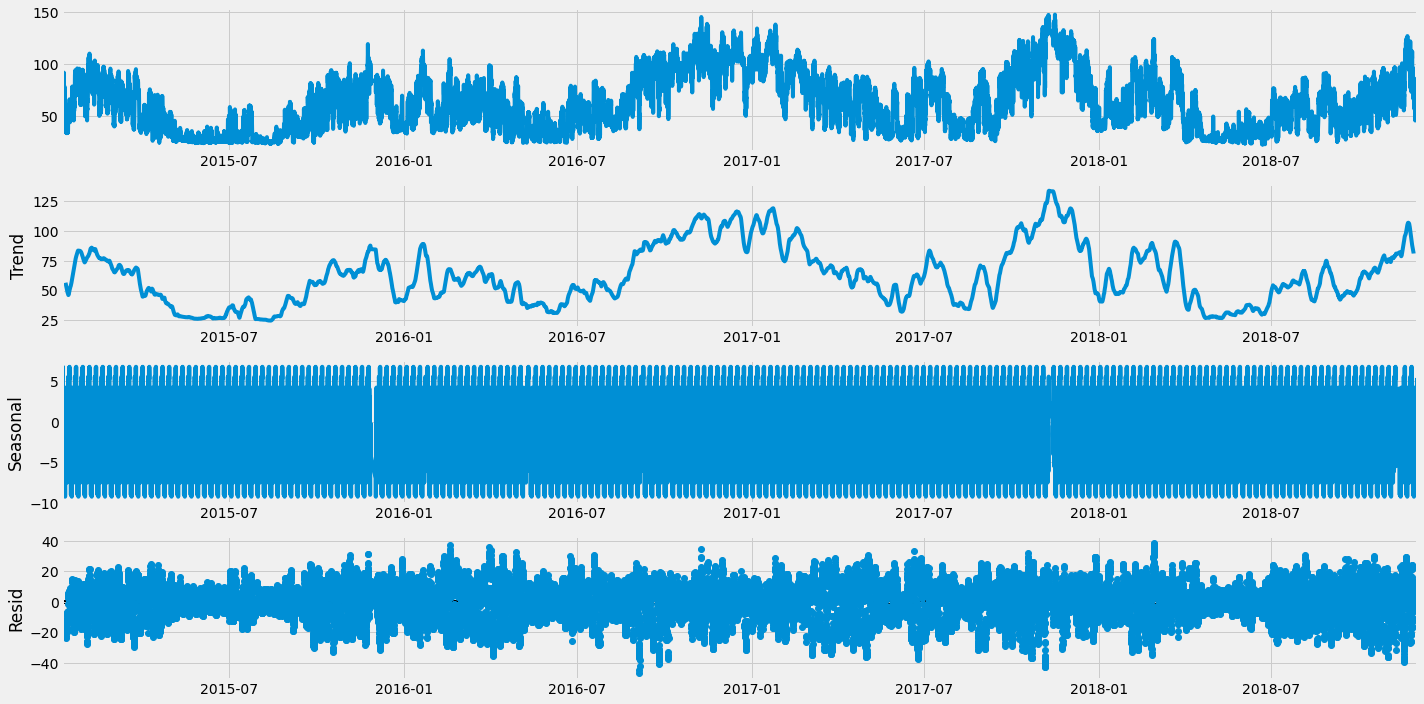

In [12]:
fig = sd_24.plot()
fig.set_size_inches(20,10)
plt.tight_layout();

#### Auto search

In [ ]:
import pmdarima as pm

model = pm.auto_arima(y.iloc[:-48], z.iloc[:-48], start_p=1, q=0, test='adf', max_p=4, d=0, 
                      seasonal=True, start_P=1, max_P=4, Q=0, D=0, m=12, #freq='D', 
                      njobs=-1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=277.53 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=362224.221, Time=20.95 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=135.85 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=302824.821, Time=108.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=372429.763, Time=22.82 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=323414.146, Time=41.51 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=264557.882, Time=169.83 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=268395.211, Time=152.65 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=96.22 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=263281.622, Time=540.56 sec


MemoryError: Unable to allocate 210. MiB for an array with shape (26, 26, 40766) and data type float64

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(endog=y.iloc[:-48].values, exog=z.iloc[:-48].values, order=(0,0,1), seasonal_order=(1,1,2,12), 
                enforce_stationarity=False, enforce_invertibility=False, measurement_error=False)

sarima_results = model.fit()
print(sarima_results.summary()) 

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                40765
Model:             SARIMAX(0, 0, 1)x(1, 1, [1, 2], 12)   Log Likelihood             -129715.373
Date:                                 Tue, 18 Jan 2022   AIC                         259442.746
Time:                                         12:12:30   BIC                         259494.434
Sample:                                              0   HQIC                        259459.093
                                               - 40765                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0630      0.001     99.269      0.000       0.062       0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


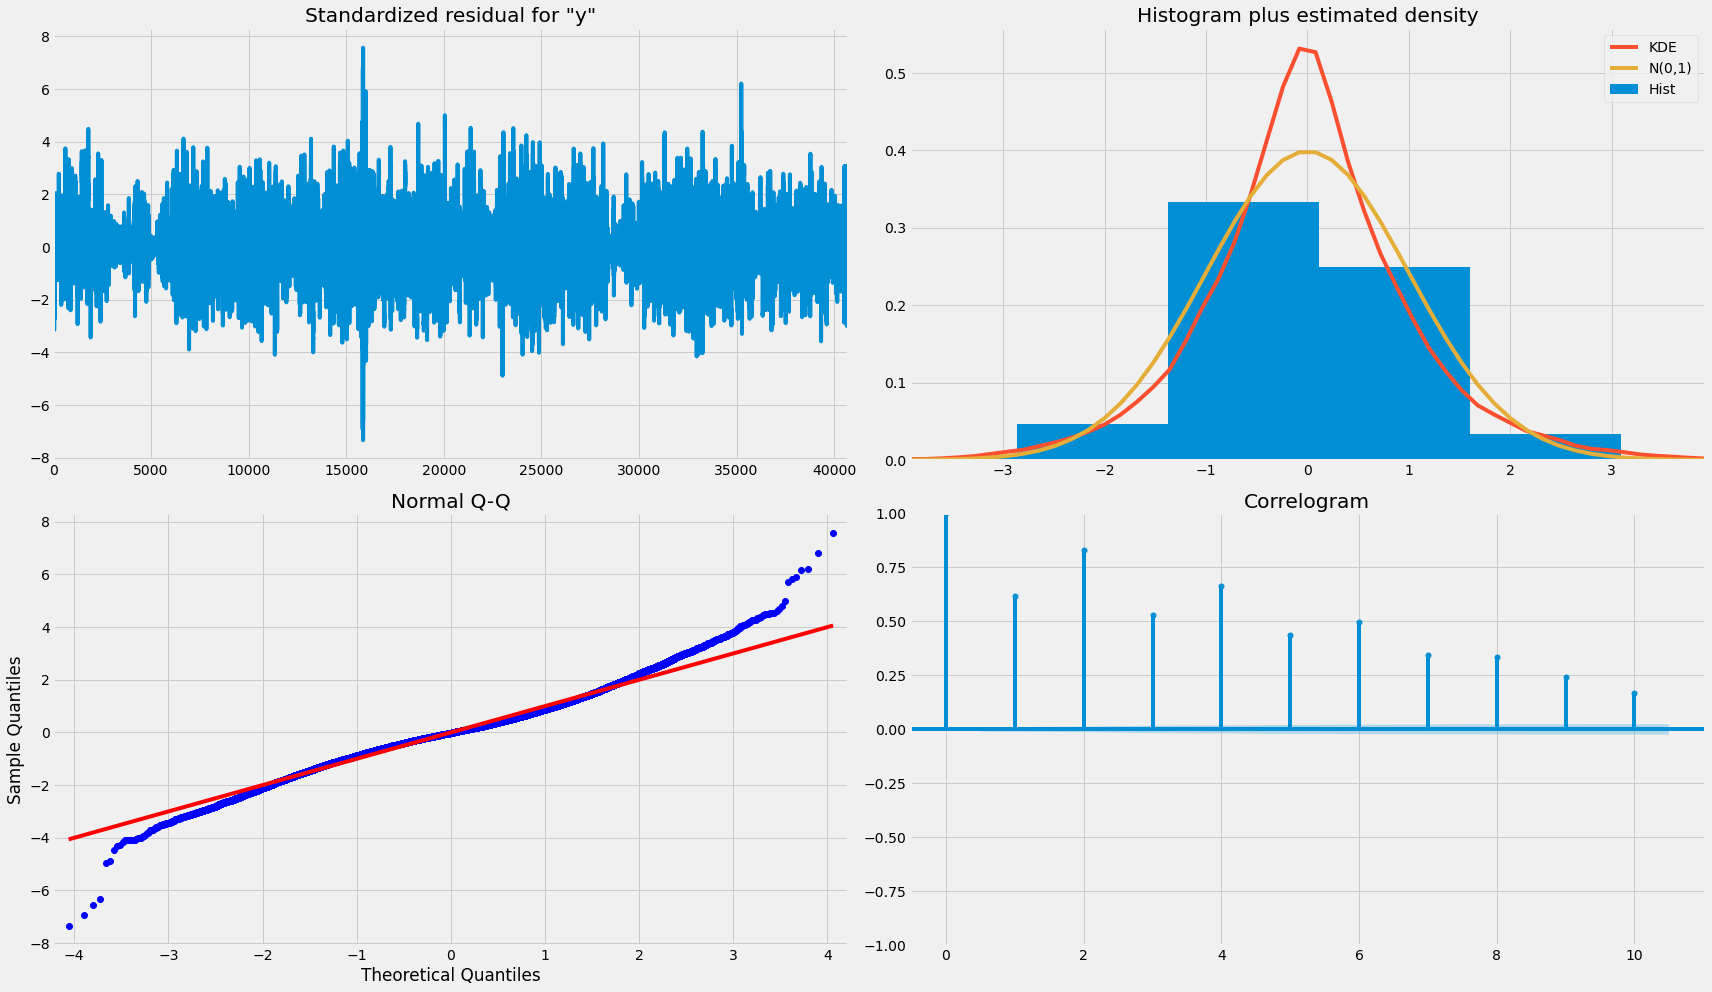

In [23]:
plt.rcParams['figure.figsize'] = (24,5)
plt.style.use('fivethirtyeight')

sarima_results.plot_diagnostics(figsize=(24, 14)); #,lags=33
plt.tight_layout();

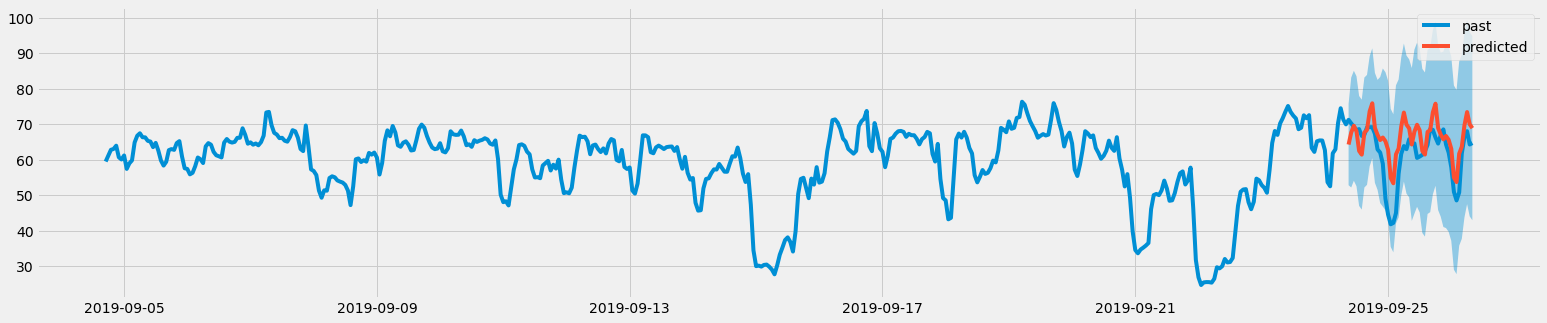

In [24]:
sarima_pred = sarima_results.get_forecast(48, exog=z.iloc[-48:].values) #df_test.shape[0] or len(df_test)
sarima_mean = sarima_pred.predicted_mean

conf_int = sarima_pred.conf_int()
dates = z.iloc[-48:].index

plt.figure()
plt.plot(y.iloc[-520:].index, y.carbon_intensity_avg.iloc[-520:], label='past');
plt.plot(dates, sarima_mean, label='predicted');
plt.fill_between(dates, conf_int[:, 0], conf_int[:, 1], alpha=0.4);
plt.legend();

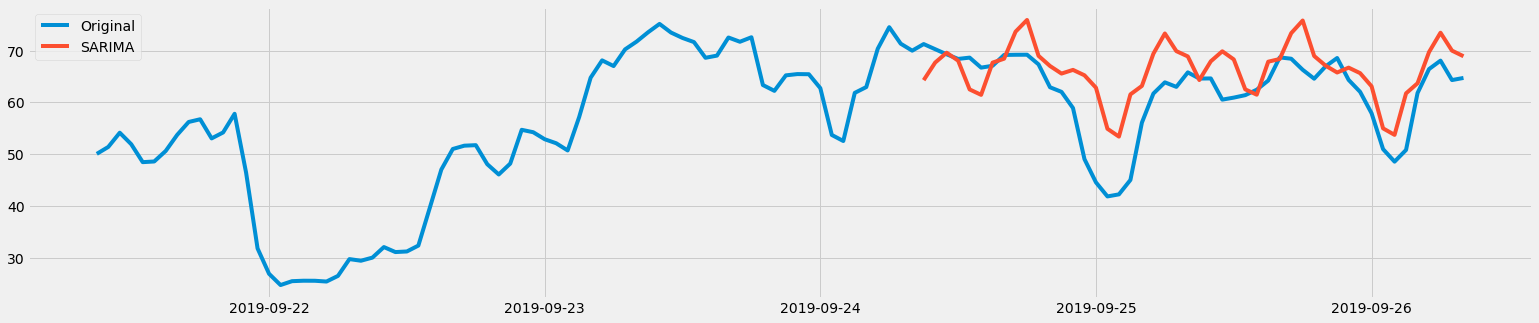

In [25]:
plt.figure(figsize=(24,5))
plt.plot(y.iloc[-120:], label='Original');
plt.plot(z.iloc[-48:].index, sarima_mean, label='SARIMA');
plt.legend()
plt.show()

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(endog=y.iloc[:-48].values, exog=z.iloc[:-48].values, order=(0,1,1), seasonal_order=(1,1,2,12), 
                trend='ct', enforce_stationarity=False, enforce_invertibility=False, measurement_error=False)

sarima_results = model.fit()
print(sarima_results.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MemoryError: Unable to allocate 473. MiB for an array with shape (39, 39, 40765) and data type float64

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


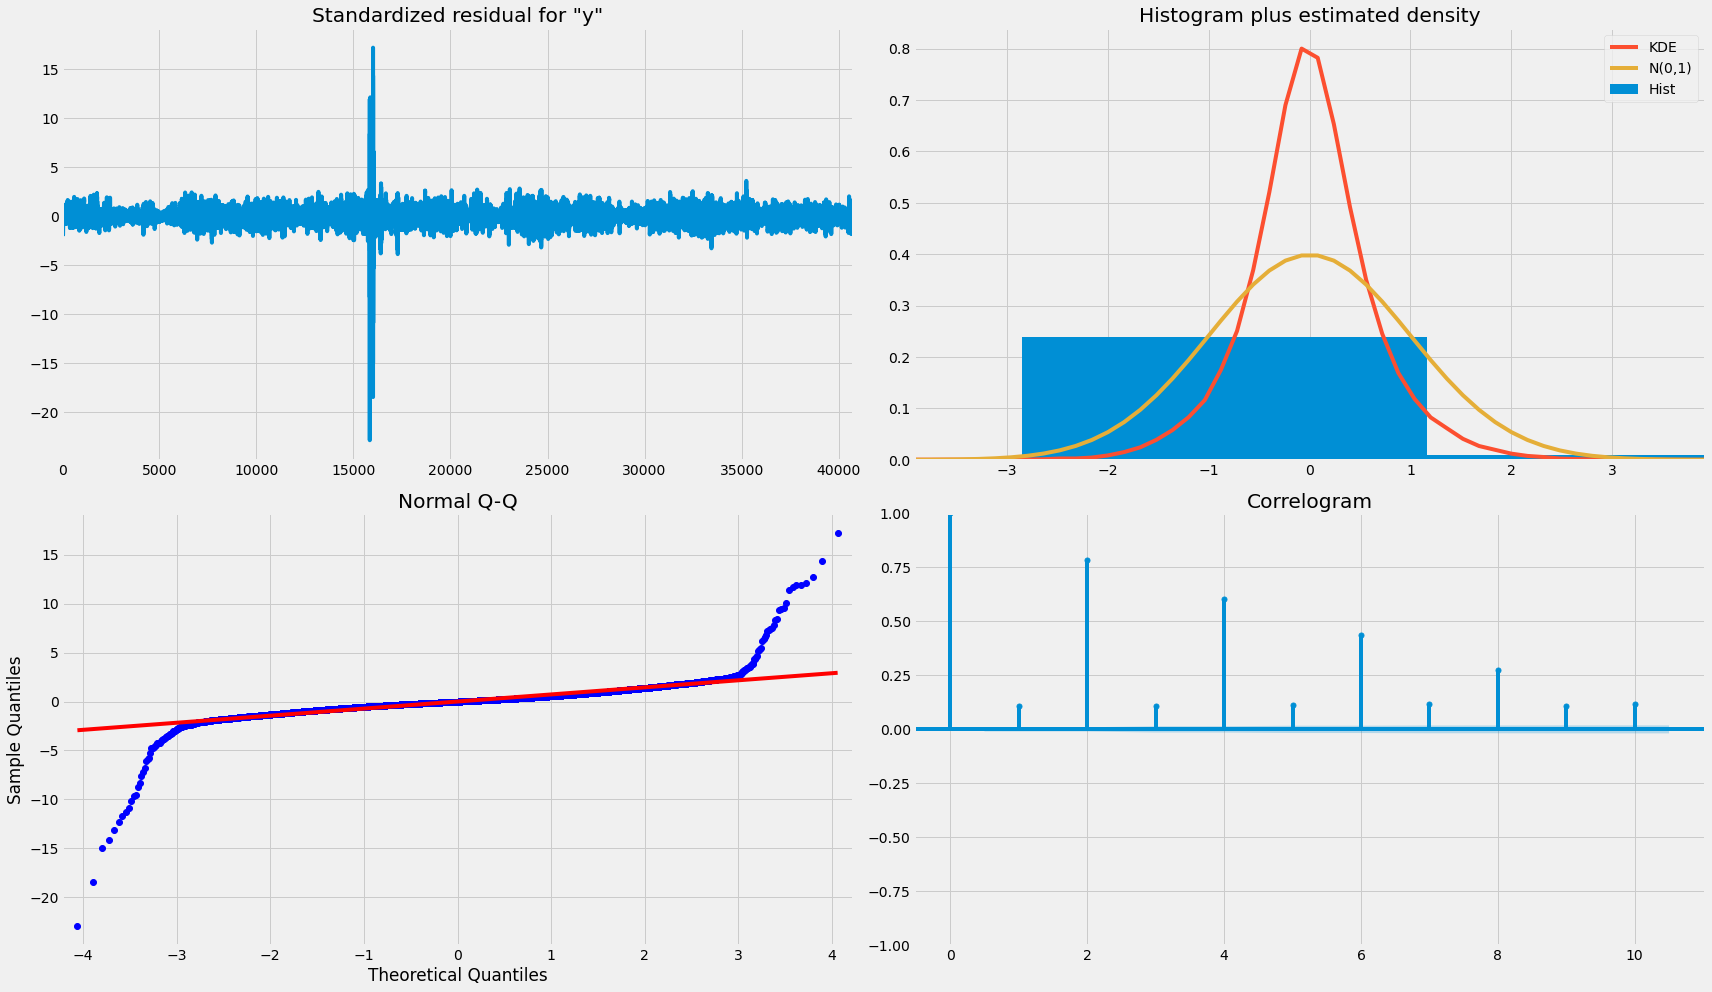

In [27]:
plt.rcParams['figure.figsize'] = (24,5)
plt.style.use('fivethirtyeight')

sarima_results.plot_diagnostics(figsize=(24, 14)); #,lags=33
plt.tight_layout();

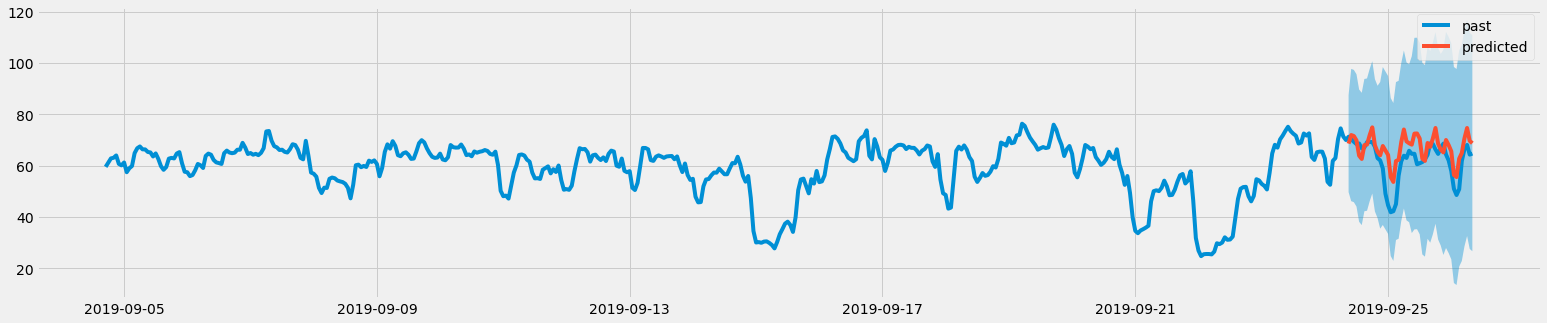

In [28]:
sarima_pred = sarima_results.get_forecast(48, exog=z.iloc[-48:].values) #df_test.shape[0] or len(df_test)
sarima_mean = sarima_pred.predicted_mean

conf_int = sarima_pred.conf_int()
dates = z.iloc[-48:].index

plt.figure()
plt.plot(y.iloc[-520:].index, y.carbon_intensity_avg.iloc[-520:], label='past');
plt.plot(dates, sarima_mean, label='predicted');
plt.fill_between(dates, conf_int[:, 0], conf_int[:, 1], alpha=0.4);
plt.legend();

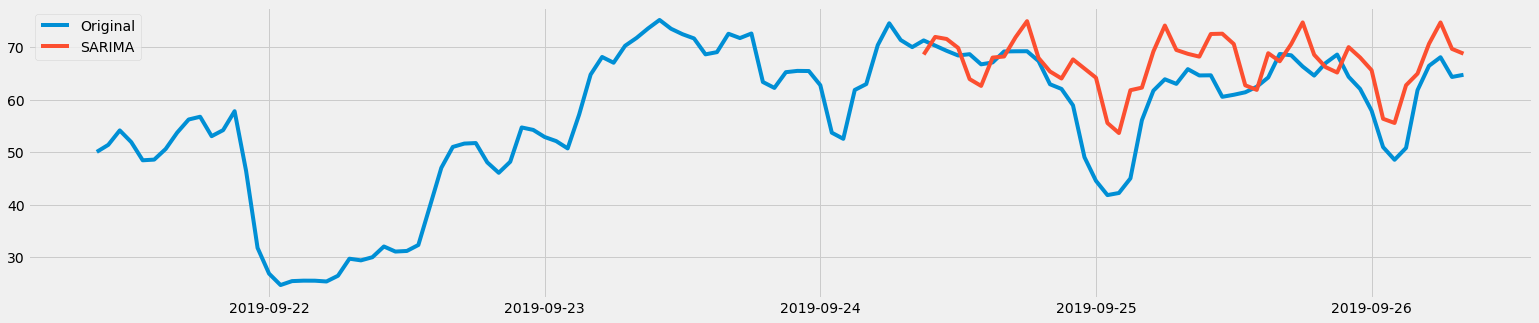

In [29]:
plt.figure(figsize=(24,5))
plt.plot(y.iloc[-120:], label='Original');
plt.plot(z.iloc[-48:].index, sarima_mean, label='SARIMA');
plt.legend()
plt.show()

#### SARIMAX(3, 1, 2)*(2, 0, 1, 12) modeling

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


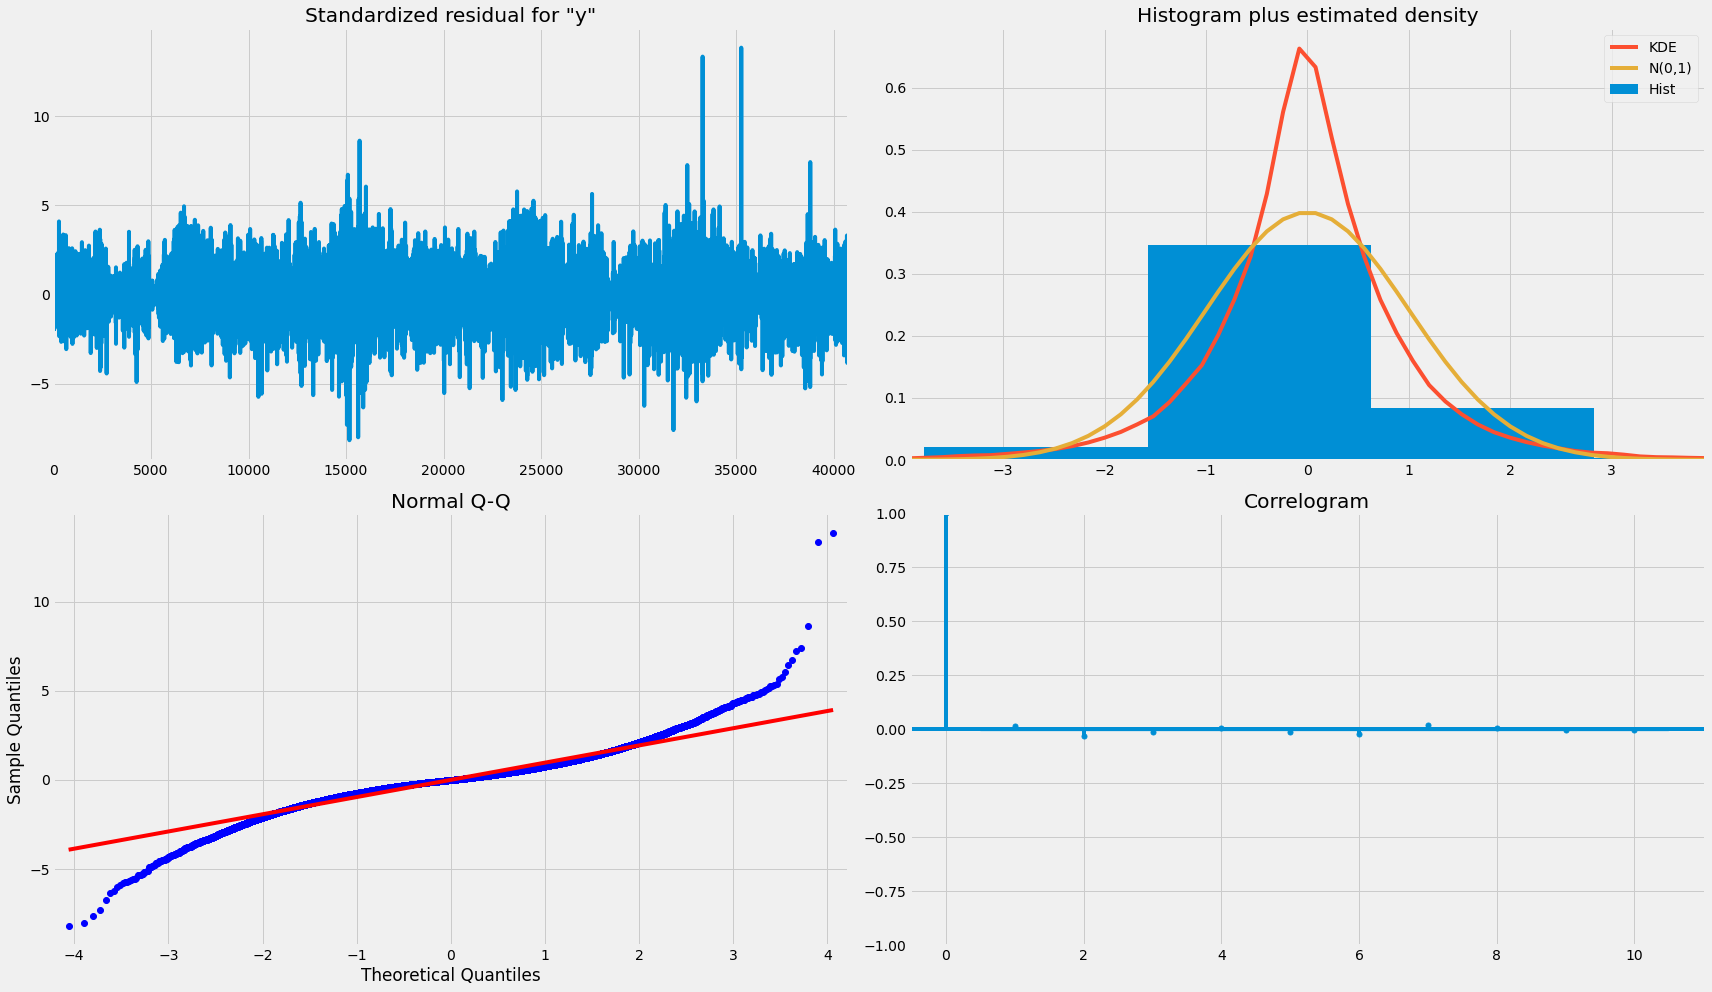

In [29]:
plt.rcParams['figure.figsize'] = (24,5)
plt.style.use('fivethirtyeight')

sarima_results.plot_diagnostics(figsize=(24, 14)); #,lags=33
plt.tight_layout();

In [30]:
sarima_pred = sarima_results.get_forecast(48, exog=z.iloc[-48:].values) #df_test.shape[0] or len(df_test)
sarima_mean = sarima_pred.predicted_mean

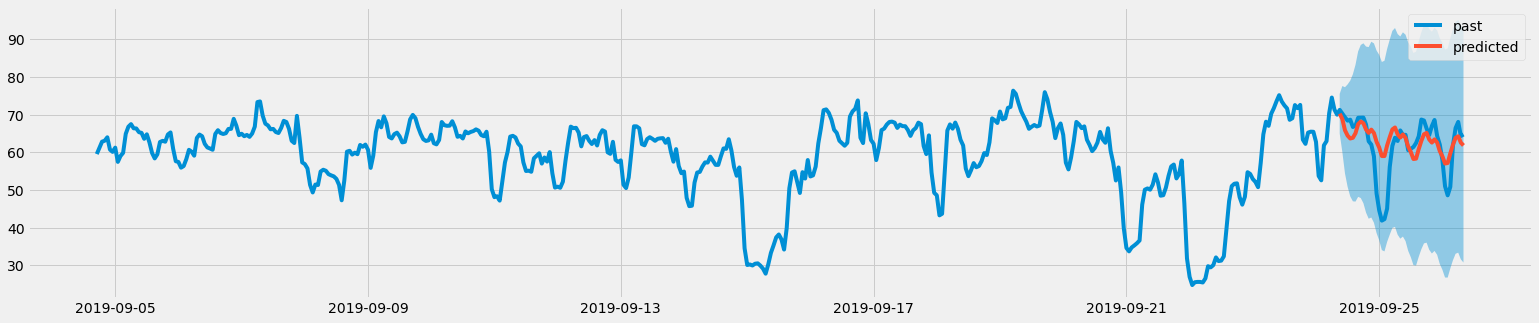

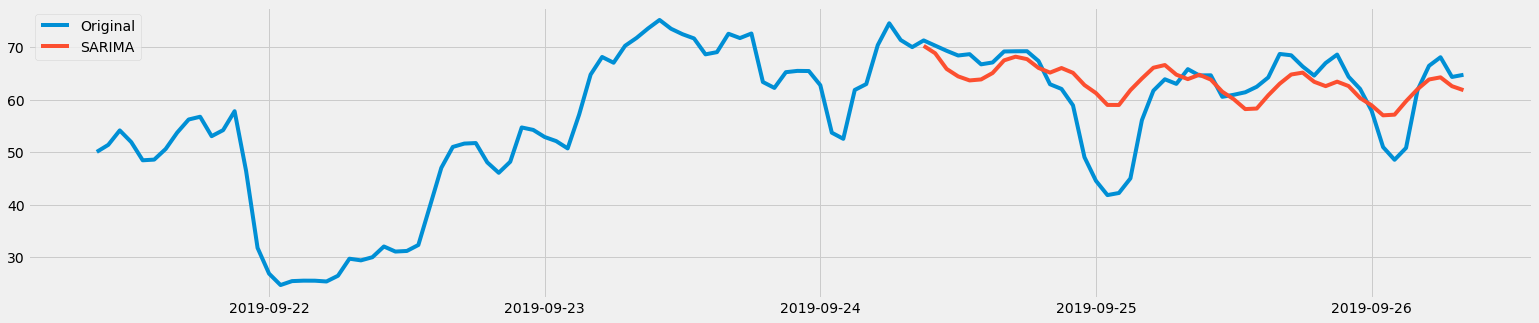

#### SARIMAX (3,1,0)*(3,1,0,12) without trend

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(endog=y.iloc[:-48].values, exog=z.iloc[:-48].values, order=(3,1,0), seasonal_order=(3,1,0,12), 
                enforce_stationarity=False, enforce_invertibility=False, measurement_error=False)

sarima_results = model.fit()


KeyboardInterrupt



In [22]:
print(sarima_results.summary()) #.tables[1]

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                15099
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 24)   Log Likelihood              -35848.216
Date:                            Wed, 12 Jan 2022   AIC                          71708.432
Time:                                    14:22:50   BIC                          71754.136
Sample:                                         0   HQIC                         71723.595
                                          - 15099                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0317      0.004      7.523      0.000       0.023       0.040
ar.L1          0.3095      0.005   

In [24]:
sarima_pred = sarima_results.get_forecast(48, exog=z.iloc[-48:].values) #df_test.shape[0] or len(df_test)
sarima_mean = sarima_pred.predicted_mean

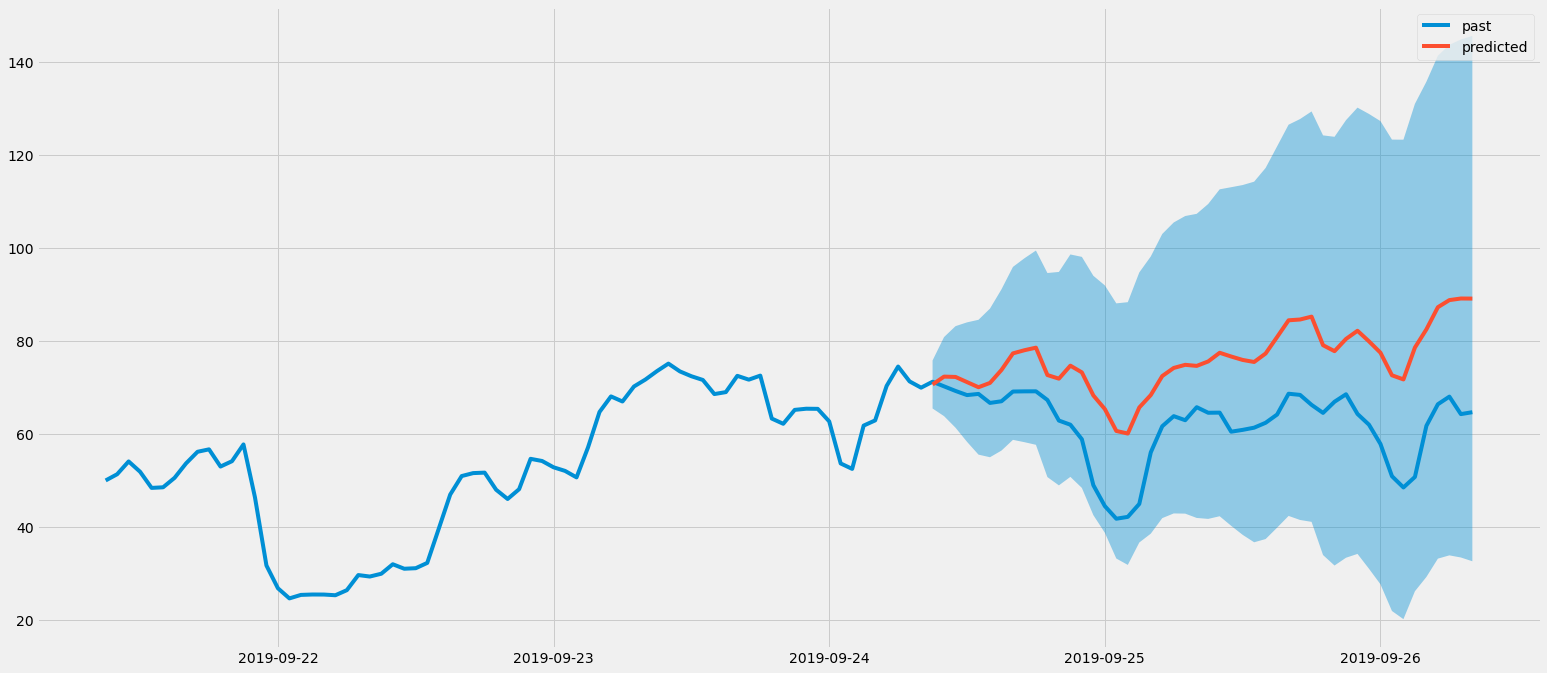

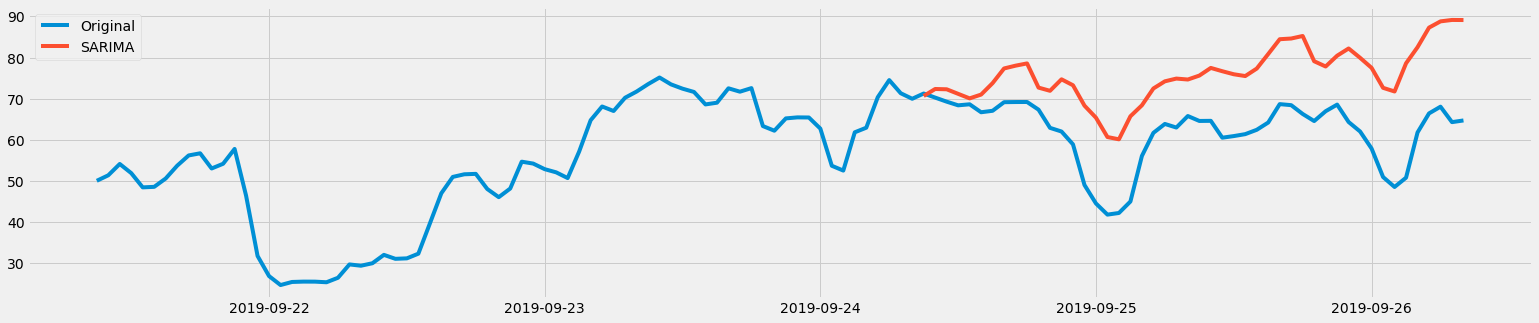

In [27]:
plt.figure(figsize=(24,5))
plt.plot(y.iloc[-120:], label='Original');
plt.plot(z.iloc[-48:].index, sarima_mean, label='SARIMA');
plt.legend()
plt.show()

#### With trend

In [ ]:
model = SARIMAX(endog=y.iloc[:-48].values, exog=w.iloc[:-48].values, order=(1,0,1), seasonal_order=(2,1,0,12), 
                enforce_stationarity=True, enforce_invertibility=True, measurement_error=False)

sarima_results = model.fit()
print(sarima_results.summary())

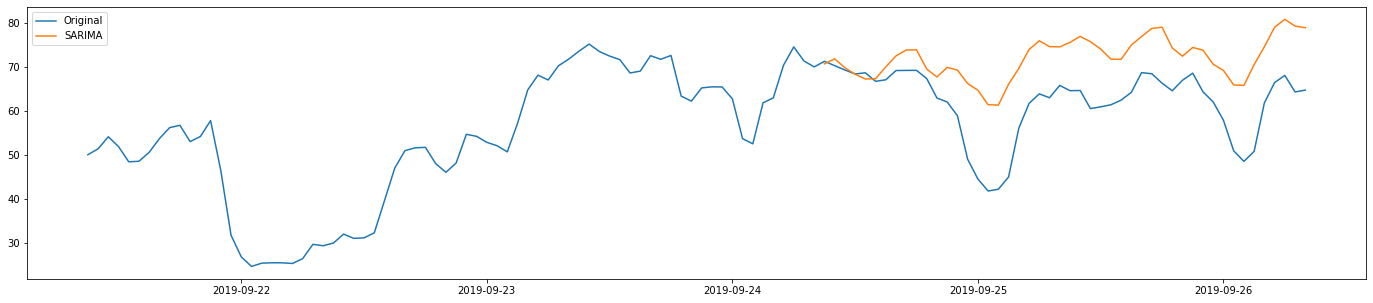

In [144]:
sarima_pred = sarima_results.get_forecast(48, exog=w.iloc[-48:].values) #df_test.shape[0] or len(df_test)
sarima_mean = sarima_pred.predicted_mean

plt.figure(figsize=(24,5))
plt.plot(y.iloc[-120:], label='Original');
plt.plot(w.iloc[-48:].index, sarima_mean, label='SARIMA');
plt.legend()
plt.show()